#### Tweak 2.2 — Label Smoothing Regularization

#### 1.1 Environment Check

In [136]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

In [137]:
# reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# device selection: CUDA > MPS > CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
elif hasattr(torch.backends, 'mps') and torch.backends.mps.is_available():
    device = torch.device('mps')
else:
    device = torch.device('cpu')

print(f'PyTorch version : {torch.__version__}')
print(f'Device          : {device}')
if device.type == 'cuda':
    print(f'GPU             : {torch.cuda.get_device_name(0)}')

PyTorch version : 2.9.0+cu128
Device          : cuda
GPU             : Tesla T4


#### 1.2 The Subset

In [138]:
def get_cifar10_subsets(n_train=5000, n_test=1000, batch_size=64, num_workers=2):
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465),
                             (0.2470, 0.2435, 0.2616))
    ])

    full_train = torchvision.datasets.CIFAR10(
        root='../data', train=True, download=True, transform=transform)
    full_test = torchvision.datasets.CIFAR10(
        root='../data', train=False, download=True, transform=transform)

    train_subset = Subset(full_train, range(n_train))
    test_subset  = Subset(full_test,  range(n_test))

    train_loader = DataLoader(train_subset, batch_size=batch_size,
                              shuffle=True, num_workers=num_workers)
    val_loader   = DataLoader(test_subset,  batch_size=batch_size,
                              shuffle=False, num_workers=num_workers)

    return train_loader, val_loader, full_train.classes

In [139]:
train_loader, val_loader, classes = get_cifar10_subsets()

print(f'Training samples   : {len(train_loader.dataset)}')
print(f'Validation samples : {len(val_loader.dataset)}')
print(f'Classes            : {classes}')
print(f'Batch size         : {train_loader.batch_size}')

# quick sanity peek
imgs, labels = next(iter(train_loader))
print(f'Batch shape        : {imgs.shape}')  # [64, 3, 32, 32]

Training samples   : 5000
Validation samples : 1000
Classes            : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
Batch size         : 64
Batch shape        : torch.Size([64, 3, 32, 32])


### 1.3 The Evaluation Suite

In [140]:
def count_parameters(model):
    """Return total number of trainable parameters."""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [141]:
@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    """Compute average loss and accuracy on a dataloader."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100.0 * correct / total
    return avg_loss, accuracy

In [142]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, epochs=15, scheduler=None):
    """
    Standard training loop. Returns history dict with per-epoch metrics.
    Optionally steps a scheduler each batch if provided.
    """
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [],   'val_acc': []
    }
    best_val_acc = 0.0
    best_weights = None

    for epoch in range(1, epochs + 1):
        # --- train ---
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            if scheduler is not None:
                scheduler.step()

            running_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc  = 100.0 * correct / total

        # --- validate ---
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        # record
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        # checkpoint best
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_weights = copy.deepcopy(model.state_dict())

        print(f'Epoch {epoch:3d}/{epochs}  |  '
              f'Train Loss: {train_loss:.4f}  Acc: {train_acc:.2f}%  |  '
              f'Val Loss: {val_loss:.4f}  Acc: {val_acc:.2f}%')

    # restore best weights
    if best_weights:
        model.load_state_dict(best_weights)
    print(f'\nBest validation accuracy: {best_val_acc:.2f}%')
    return history

In [143]:
def plot_history(history, title='Training History'):
    """Plot loss and accuracy curves side by side."""
    epochs = range(1, len(history['train_loss']) + 1)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    # --- loss ---
    ax1.plot(epochs, history['train_loss'], 'o-', label='Train Loss')
    ax1.plot(epochs, history['val_loss'],   's-', label='Val Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title(f'{title} \u2014 Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # --- accuracy ---
    ax2.plot(epochs, history['train_acc'], 'o-', label='Train Acc')
    ax2.plot(epochs, history['val_acc'],   's-', label='Val Acc')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy (%)')
    ax2.set_title(f'{title} \u2014 Accuracy')
    ax2.legend()
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

#### 2.1 Build Model 2.2 — Stacked Conv Blocks + Label Smoothing

Uses the best architecture from Phase 1 (Model 1.3: Stacked Conv Blocks + BN + GAP).
The only change: **label_smoothing=0.1** added to CrossEntropyLoss.
Instead of hard targets (0 or 1), the model trains against soft targets (0.01 / 0.91),
which prevents overconfident predictions and acts as a regularizer.

In [144]:
class DeepCNN_StackedBlocks(nn.Module):
    """
    Stacked Conv Blocks architecture (from Model 1.3).

    Architecture:
        Block 1: (Conv2d(3->32, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2)
        Block 2: (Conv2d(32->64, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2)
        Block 3: (Conv2d(64->128, 3x3) -> BatchNorm -> ReLU) x 2 -> MaxPool(2)
        AdaptiveAvgPool2d(1)  (GAP)
        Flatten -> FC(128 -> 10)
    """

    def __init__(self):
        super().__init__()

        # Block 1: 3 -> 32 channels
        self.block1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Block 2: 32 -> 64 channels
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Block 3: 64 -> 128 channels
        self.block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        # Global Average Pooling + Classifier
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.classifier(x)
        return x

In [145]:
model = DeepCNN_StackedBlocks().to(device)
print(model)
print(f'\nTrainable parameters: {count_parameters(model):,}')

DeepCNN_StackedBlocks(
  (block1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block3): Sequential(
    (0): C

### 2.2 Train for 15 Epochs (with label_smoothing=0.1)

In [146]:
EPOCHS = 15
LR = 1e-3
LABEL_SMOOTHING = 0.1

criterion = nn.CrossEntropyLoss(label_smoothing=LABEL_SMOOTHING)
optimizer = optim.Adam(model.parameters(), lr=LR)

print(f'Optimizer       : Adam (lr={LR})')
print(f'Loss fn         : CrossEntropyLoss(label_smoothing={LABEL_SMOOTHING})')
print(f'Epochs          : {EPOCHS}')
print(f'Device          : {device}')
print(f'Regularizer     : Label Smoothing ({LABEL_SMOOTHING})')
print('-' * 65)

start = time.time()
history = train_model(model, train_loader, val_loader, criterion,
                      optimizer, device, epochs=EPOCHS)
elapsed = time.time() - start
print(f'\nTraining time: {elapsed:.1f}s')

Optimizer       : Adam (lr=0.001)
Loss fn         : CrossEntropyLoss(label_smoothing=0.1)
Epochs          : 15
Device          : cuda
Regularizer     : Label Smoothing (0.1)
-----------------------------------------------------------------
Epoch   1/15  |  Train Loss: 1.8228  Acc: 37.64%  |  Val Loss: 2.0247  Acc: 36.00%
Epoch   2/15  |  Train Loss: 1.5830  Acc: 49.76%  |  Val Loss: 1.8503  Acc: 41.80%
Epoch   3/15  |  Train Loss: 1.4651  Acc: 56.36%  |  Val Loss: 1.7156  Acc: 44.60%
Epoch   4/15  |  Train Loss: 1.3796  Acc: 60.68%  |  Val Loss: 1.5194  Acc: 52.60%
Epoch   5/15  |  Train Loss: 1.2764  Acc: 65.96%  |  Val Loss: 1.6074  Acc: 49.20%
Epoch   6/15  |  Train Loss: 1.2168  Acc: 69.12%  |  Val Loss: 1.4346  Acc: 58.80%
Epoch   7/15  |  Train Loss: 1.1471  Acc: 73.16%  |  Val Loss: 1.5224  Acc: 56.20%
Epoch   8/15  |  Train Loss: 1.0604  Acc: 76.94%  |  Val Loss: 1.5362  Acc: 56.10%
Epoch   9/15  |  Train Loss: 1.0023  Acc: 80.68%  |  Val Loss: 1.5144  Acc: 57.10%
Epoch  10/15 

#### 2.3 Visualize Training Curves

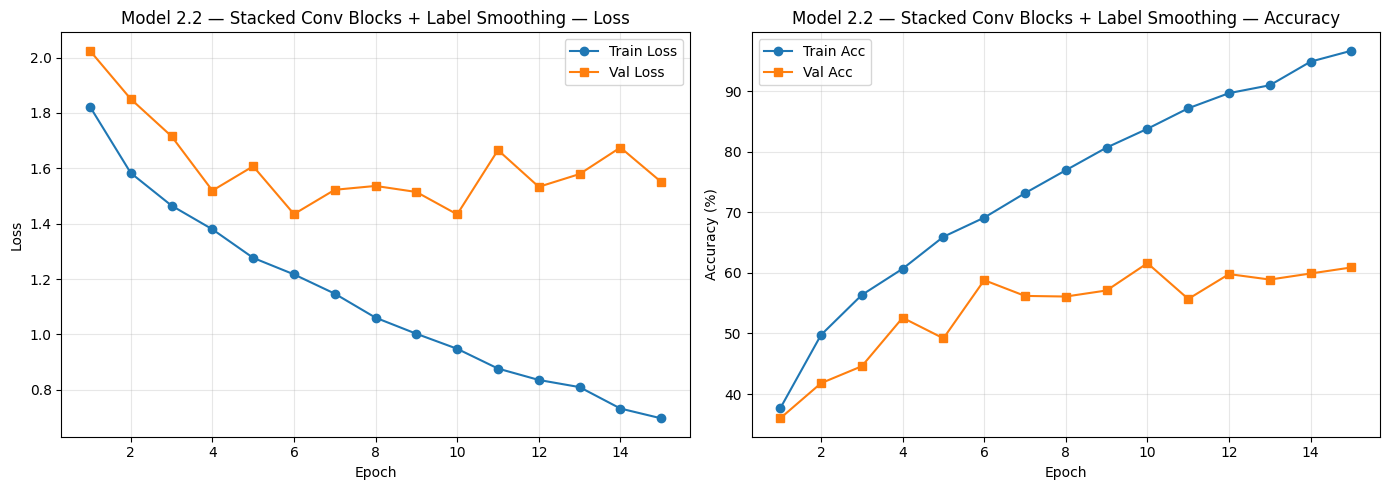

In [148]:
plot_history(history, title='Model 2.2 \u2014 Stacked Conv Blocks + Label Smoothing')

### 2.4 Results Summary

In [150]:
final_train_acc = history['train_acc'][-1]
final_val_acc   = history['val_acc'][-1]
peak_val_acc    = max(history['val_acc'])
gap             = final_train_acc - final_val_acc

print('=' * 55)
print('   MODEL 2.2 \u2014 RESULTS SUMMARY (Label Smoothing)')
print('=' * 55)
print(f'  Parameters       : {count_parameters(model):,}')
print(f'  Final Train Acc  : {final_train_acc:.2f}%')
print(f'  Final Val Acc    : {final_val_acc:.2f}%')
print(f'  Peak Val Acc     : {peak_val_acc:.2f}%')
print(f'  Train-Val Gap    : {gap:+.2f}%')
print(f'  Final Train Loss : {history["train_loss"][-1]:.4f}')
print(f'  Final Val Loss   : {history["val_loss"][-1]:.4f}')
print(f'  Diagnosis      : Slight improvement, still overfitting.')
print('=' * 55)

   MODEL 2.2 — RESULTS SUMMARY (Label Smoothing)
  Parameters       : 289,194
  Final Train Acc  : 96.66%
  Final Val Acc    : 60.90%
  Peak Val Acc     : 61.60%
  Train-Val Gap    : +35.76%
  Final Train Loss : 0.6968
  Final Val Loss   : 1.5508
  Diagnosis      : Slight improvement, still overfitting.
